# This is our workspace for data analysis!

In [2]:
# feel free to add more

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Create connection to atlas
conn_atlas = sqlite3.connect('./atlas.db')
c_atlas = conn_atlas.cursor()

In [4]:
LIST_TABLES_CMD = "SELECT name FROM sqlite_master WHERE type='table';"

# You can switch this to any table
LIST_COLUMNS_CMD_ATLAS = "PRAGMA table_info('Atlas_of_Surveillance_20201007');"

c_atlas.execute(LIST_TABLES_CMD)
conn_atlas.commit()

for row in c_atlas:
  print(row)

c_atlas.execute(LIST_COLUMNS_CMD_ATLAS)
conn_atlas.commit()

for column in c_atlas:
    print(column)

('Atlas_of_Surveillance_20201007',)
('acs2017_county_data',)
('acs2015_county_data',)
(0, 'AOSNUMBER', 'TEXT', 0, None, 0)
(1, 'City', 'TEXT', 0, None, 0)
(2, 'County', 'TEXT', 0, None, 0)
(3, 'State', 'TEXT', 0, None, 0)
(4, 'Agency', 'TEXT', 0, None, 0)
(5, 'Type of LEA', 'TEXT', 0, None, 0)
(6, 'Summary', 'TEXT', 0, None, 0)
(7, 'Type of Juris', 'TEXT', 0, None, 0)
(8, 'Technology', 'TEXT', 0, None, 0)
(9, 'Vendor', 'TEXT', 0, None, 0)
(10, 'Link 1', 'TEXT', 0, None, 0)
(11, 'Link 1 Snapshot', 'TEXT', 0, None, 0)
(12, 'Link 1 Source', 'TEXT', 0, None, 0)
(13, 'Link 1 Type', 'TEXT', 0, None, 0)
(14, 'Link 1 Date', 'TEXT', 0, None, 0)
(15, 'Link 2', 'TEXT', 0, None, 0)
(16, 'Link 2 Snapshot', 'TEXT', 0, None, 0)
(17, 'Link 2 Source', 'TEXT', 0, None, 0)
(18, 'Link 2 Type', 'TEXT', 0, None, 0)
(19, 'Link 2 Date', 'TEXT', 0, None, 0)
(20, 'Link 3', 'TEXT', 0, None, 0)
(21, 'Link 3 Snapshot', 'TEXT', 0, None, 0)
(22, 'Link 3 Source', 'TEXT', 0, None, 0)
(23, 'Link 3 Type', 'TEXT', 0, Non

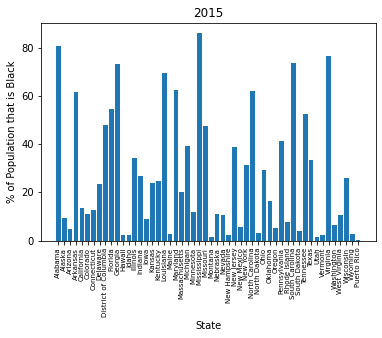

In [5]:
# Feel free to change to demographic groups
cursor_2015_black = conn_atlas.cursor()
SELECT_BLACK_2015 = "SELECT Black from acs2015_county_data"
cursor_2015_black.execute(SELECT_BLACK_2015)

cursor_2015_state = conn_atlas.cursor()
SELECT_STATE_2015 = "SELECT State from acs2015_county_data"
cursor_2015_state.execute(SELECT_STATE_2015)
black_2015 = [float(a[0]) for a in cursor_2015_black]
state_2015 = [a[0] for a in cursor_2015_state]

plot_state_race = plt.bar(state_2015, black_2015)
plt.title('2015')
plt.xlabel('State')
plt.ylabel('% of Population that is Black')
plt.xticks(fontsize=7, rotation=90)
plt.show()

# OLS workspace
- array with number of each race in a county (multiply percentage by total pop)
- array with total number of surveillance devices in a county (need SQL query for this)
    - SQL query to join 

In [7]:
# Number of black people in each county
# black_2015

# Feel free to change to demographic groups
cursor_2015_total_pop = conn_atlas.cursor()
SELECT_TOTAL_POP_2015 = "SELECT TotalPop from acs2015_county_data"
cursor_2015_total_pop.execute(SELECT_TOTAL_POP_2015)
total_pop_2015 = [float(a[0]) for a in cursor_2015_total_pop]
total_pop_black_2015 = []
for i in range(len(total_pop_2015)) :
    total_pop_black_2015.append(total_pop_2015[i] * black_2015[i])

In [9]:
# select *
# from Db1.dbo.Clients c
# join Db2.dbo.Messages m on c.ClientId = m.ClientId


#COUNT_QUERY = 'SELECT * FROM acs2015_county_data INNER JOIN Atlas_of_Surveillance_20201007 ON acs2015_county_data.County = Atlas_of_Surveillance_20201007.County'
#JOIN_QUERY = 'SELECT State FROM Atlas_of_Surveillance_20201007;'
JOIN_QUERY = 'SELECT * FROM Atlas_of_Surveillance_20201007, acs2015_county_data WHERE '
c_atlas = conn_atlas.cursor()
c_atlas.execute(JOIN_QUERY)
conn_atlas.commit()
i = 0
for row in c_atlas:
  print(row, "\n")
  print("I:", i)
  i += 1

('Virginia',) 

I: 0
('Illinois',) 

I: 1
('Georgia',) 

I: 2
('Illinois',) 

I: 3
('North Carolina',) 

I: 4
('New York',) 

I: 5
('Pennsylvania',) 

I: 6
('New York',) 

I: 7
('Oregon',) 

I: 8
('North Carolina',) 

I: 9
('Georgia',) 

I: 10
('New Mexico',) 

I: 11
('Colorado',) 

I: 12
('Texas',) 

I: 13
('Florida',) 

I: 14
('North Dakota',) 

I: 15
('Colorado',) 

I: 16
('New Mexico',) 

I: 17
('Texas',) 

I: 18
('New York',) 

I: 19
('Alabama',) 

I: 20
('North Carolina',) 

I: 21
('Texas',) 

I: 22
('Ohio',) 

I: 23
('Pennsylvania',) 

I: 24
('Texas',) 

I: 25
('Ohio',) 

I: 26
('Indiana',) 

I: 27
('Kentucky',) 

I: 28
('Florida',) 

I: 29
('Florida',) 

I: 30
('West Virginia',) 

I: 31
('Arizona',) 

I: 32
('Texas',) 

I: 33
('Texas',) 

I: 34
('Illinois',) 

I: 35
('Pennsylvania',) 

I: 36
('Arizona',) 

I: 37
('Ohio',) 

I: 38
('North Carolina',) 

I: 39
('New Jersey',) 

I: 40
('New York',) 

I: 41
('New York',) 

I: 42
('New York',) 

I: 43
('Colorado',) 

I: 44
('New York

I: 380
('Georgia',) 

I: 381
('Arkansas',) 

I: 382
('Arkansas',) 

I: 383
('Arkansas',) 

I: 384
('Arkansas',) 

I: 385
('Arkansas',) 

I: 386
('Arizona',) 

I: 387
('Arizona',) 

I: 388
('Arizona',) 

I: 389
('Arizona',) 

I: 390
('California',) 

I: 391
('California',) 

I: 392
('California',) 

I: 393
('California',) 

I: 394
('California',) 

I: 395
('California',) 

I: 396
('California',) 

I: 397
('California',) 

I: 398
('California',) 

I: 399
('California',) 

I: 400
('California',) 

I: 401
('California',) 

I: 402
('California',) 

I: 403
('California',) 

I: 404
('Connecticut',) 

I: 405
('California',) 

I: 406
('California',) 

I: 407
('California',) 

I: 408
('California',) 

I: 409
('California',) 

I: 410
('California',) 

I: 411
('California',) 

I: 412
('California',) 

I: 413
('California',) 

I: 414
('California',) 

I: 415
('California',) 

I: 416
('California',) 

I: 417
('California',) 

I: 418
('Colorado',) 

I: 419
('Colorado',) 

I: 420
('Colorado',) 

I: 42

I: 1005
('Alabama',) 

I: 1006
('Maryland',) 

I: 1007
('Texas',) 

I: 1008
('California',) 

I: 1009
('Oregon',) 

I: 1010
('California',) 

I: 1011
('Georgia',) 

I: 1012
('Iowa',) 

I: 1013
('California',) 

I: 1014
('California',) 

I: 1015
('California',) 

I: 1016
('Delaware',) 

I: 1017
('Tennessee',) 

I: 1018
('Florida',) 

I: 1019
('Georgia',) 

I: 1020
('Oregon',) 

I: 1021
('Georgia',) 

I: 1022
('Indiana',) 

I: 1023
('Washington',) 

I: 1024
('Virginia',) 

I: 1025
('Connecticut',) 

I: 1026
('Florida',) 

I: 1027
('Arizona',) 

I: 1028
('California',) 

I: 1029
('California',) 

I: 1030
('Florida',) 

I: 1031
('Florida',) 

I: 1032
('Illinois',) 

I: 1033
('Oregon',) 

I: 1034
('Connecticut',) 

I: 1035
('Texas',) 

I: 1036
('California',) 

I: 1037
('Kansas',) 

I: 1038
('Illinois',) 

I: 1039
('Georgia',) 

I: 1040
('Oregon',) 

I: 1041
('Florida',) 

I: 1042
('California',) 

I: 1043
('Alabama',) 

I: 1044
('Florida',) 

I: 1045
('Oregon',) 

I: 1046
('Arizona',) 

I:


I: 1380
('Indiana',) 

I: 1381
('California',) 

I: 1382
('Oklahoma',) 

I: 1383
('Delaware',) 

I: 1384
('Delaware',) 

I: 1385
('Colorado',) 

I: 1386
('Texas',) 

I: 1387
('Iowa',) 

I: 1388
('Oregon',) 

I: 1389
('Michigan',) 

I: 1390
('Texas',) 

I: 1391
('North Dakota',) 

I: 1392
('Tennessee',) 

I: 1393
('Nebraska',) 

I: 1394
('Wisconsin',) 

I: 1395
('Kansas',) 

I: 1396
('Wisconsin',) 

I: 1397
('Florida',) 

I: 1398
('Colorado',) 

I: 1399
('Georgia',) 

I: 1400
('Minnesota',) 

I: 1401
('Nebraska',) 

I: 1402
('Nevada',) 

I: 1403
('Georgia',) 

I: 1404
('Delaware',) 

I: 1405
('Illinois',) 

I: 1406
('Ohio',) 

I: 1407
('Iowa',) 

I: 1408
('Georgia',) 

I: 1409
('Oklahoma',) 

I: 1410
('Georgia',) 

I: 1411
('Illinois',) 

I: 1412
('Illinois',) 

I: 1413
('Louisiana',) 

I: 1414
('Illinois',) 

I: 1415
('Connecticut',) 

I: 1416
('Ohio',) 

I: 1417
('Wisconsin',) 

I: 1418
('Texas',) 

I: 1419
('Minnesota',) 

I: 1420
('Kentucky',) 

I: 1421
('California',) 

I: 1422
('

('Illinois',) 

I: 1976
('Oklahoma',) 

I: 1977
('Arkansas',) 

I: 1978
('New York',) 

I: 1979
('California',) 

I: 1980
('Pennsylvania',) 

I: 1981
('Georgia',) 

I: 1982
('Texas',) 

I: 1983
('Colorado',) 

I: 1984
('Idaho',) 

I: 1985
('Indiana',) 

I: 1986
('Alabama',) 

I: 1987
('Virginia',) 

I: 1988
('Alabama',) 

I: 1989
('Tennessee',) 

I: 1990
('California',) 

I: 1991
('Arizona',) 

I: 1992
('Oregon',) 

I: 1993
('Utah',) 

I: 1994
('Arizona',) 

I: 1995
('Texas',) 

I: 1996
('California',) 

I: 1997
('California',) 

I: 1998
('California',) 

I: 1999
('California',) 

I: 2000
('California',) 

I: 2001
('California',) 

I: 2002
('California',) 

I: 2003
('Texas',) 

I: 2004
('California',) 

I: 2005
('California',) 

I: 2006
('Ohio',) 

I: 2007
('Georgia',) 

I: 2008
('Michigan',) 

I: 2009
('California',) 

I: 2010
('California',) 

I: 2011
('California',) 

I: 2012
('Oklahoma',) 

I: 2013
('Florida',) 

I: 2014
('New York',) 

I: 2015
('Nebraska',) 

I: 2016
('Wisconsin',

I: 2591
('Illinois',) 

I: 2592
('Illinois',) 

I: 2593
('Illinois',) 

I: 2594
('Illinois',) 

I: 2595
('Illinois',) 

I: 2596
('Illinois',) 

I: 2597
('Illinois',) 

I: 2598
('Illinois',) 

I: 2599
('Illinois',) 

I: 2600
('Illinois',) 

I: 2601
('Illinois',) 

I: 2602
('Illinois',) 

I: 2603
('Illinois',) 

I: 2604
('Illinois',) 

I: 2605
('California',) 

I: 2606
('California',) 

I: 2607
('Texas',) 

I: 2608
('Idaho',) 

I: 2609
('Texas',) 

I: 2610
('Minnesota',) 

I: 2611
('New York',) 

I: 2612
('Florida',) 

I: 2613
('New Jersey',) 

I: 2614
('Florida',) 

I: 2615
('Virginia',) 

I: 2616
('Illinois',) 

I: 2617
('North Carolina',) 

I: 2618
('Nevada',) 

I: 2619
('Arizona',) 

I: 2620
('Massachusetts',) 

I: 2621
('Wisconsin',) 

I: 2622
('California',) 

I: 2623
('Alaska',) 

I: 2624
('Colorado',) 

I: 2625
('Kentucky',) 

I: 2626
('Washington',) 

I: 2627
('California',) 

I: 2628
('Kentucky',) 

I: 2629
('Minnesota',) 

I: 2630
('Alaska',) 

I: 2631
('New Jersey',) 

I: 263

('New York',) 

I: 3124
('Virginia',) 

I: 3125
('California',) 

I: 3126
('Ohio',) 

I: 3127
('Massachusetts',) 

I: 3128
('Massachusetts',) 

I: 3129
('California',) 

I: 3130
('California',) 

I: 3131
('Texas',) 

I: 3132
('Rhode Island',) 

I: 3133
('Indiana',) 

I: 3134
('Kansas',) 

I: 3135
('New York',) 

I: 3136
('Georgia',) 

I: 3137
('Texas',) 

I: 3138
('Indiana',) 

I: 3139
('Texas',) 

I: 3140
('California',) 

I: 3141
('Oklahoma',) 

I: 3142
('New Hampshire',) 

I: 3143
('Texas',) 

I: 3144
('Missouri',) 

I: 3145
('Ohio',) 

I: 3146
('California',) 

I: 3147
('Texas',) 

I: 3148
('Missouri',) 

I: 3149
('Massachusetts',) 

I: 3150
('North Carolina',) 

I: 3151
('Oregon',) 

I: 3152
('Florida',) 

I: 3153
('Texas',) 

I: 3154
('New Jersey',) 

I: 3155
('Texas',) 

I: 3156
('Maryland',) 

I: 3157
('New York',) 

I: 3158
('Oklahoma',) 

I: 3159
('Missouri',) 

I: 3160
('Maryland',) 

I: 3161
('Wisconsin',) 

I: 3162
('Texas',) 

I: 3163
('Washington',) 

I: 3164
('Texas',) 

('Texas',) 

I: 3777
('New Jersey',) 

I: 3778
('Texas',) 

I: 3779
('Texas',) 

I: 3780
('Virginia',) 

I: 3781
('Texas',) 

I: 3782
('California',) 

I: 3783
('Virginia',) 

I: 3784
('Texas',) 

I: 3785
('New Jersey',) 

I: 3786
('Florida',) 

I: 3787
('Texas',) 

I: 3788
('Virginia',) 

I: 3789
('New Jersey',) 

I: 3790
('Wisconsin',) 

I: 3791
('Texas',) 

I: 3792
('Virginia',) 

I: 3793
('Florida',) 

I: 3794
('Texas',) 

I: 3795
('California',) 

I: 3796
('Texas',) 

I: 3797
('Texas',) 

I: 3798
('Ohio',) 

I: 3799
('Florida',) 

I: 3800
('Oregon',) 

I: 3801
('California',) 

I: 3802
('Maryland',) 

I: 3803
('Texas',) 

I: 3804
('Florida',) 

I: 3805
('Texas',) 

I: 3806
('Louisiana',) 

I: 3807
('Maine',) 

I: 3808
('Oklahoma',) 

I: 3809
('Michigan',) 

I: 3810
('Florida',) 

I: 3811
('Missouri',) 

I: 3812
('Nebraska',) 

I: 3813
('Illinois',) 

I: 3814
('Michigan',) 

I: 3815
('Illinois',) 

I: 3816
('Massachusetts',) 

I: 3817
('Georgia',) 

I: 3818
('Texas',) 

I: 3819
('C

('Texas',) 

I: 4254
('Georgia',) 

I: 4255
('Illinois',) 

I: 4256
('Indiana',) 

I: 4257
('California',) 

I: 4258
('Florida',) 

I: 4259
('Illinois',) 

I: 4260
('California',) 

I: 4261
('Illinois',) 

I: 4262
('Alabama',) 

I: 4263
('Illinois',) 

I: 4264
('New York',) 

I: 4265
('Illinois',) 

I: 4266
('Georgia',) 

I: 4267
('South Carolina',) 

I: 4268
('Nebraska',) 

I: 4269
('New Jersey',) 

I: 4270
('North Carolina',) 

I: 4271
('Nevada',) 

I: 4272
('Georgia',) 

I: 4273
('Pennsylvania',) 

I: 4274
('Ohio',) 

I: 4275
('Indiana',) 

I: 4276
('Illinois',) 

I: 4277
('New Jersey',) 

I: 4278
('Wisconsin',) 

I: 4279
('California',) 

I: 4280
('Florida',) 

I: 4281
('Pennsylvania',) 

I: 4282
('North Carolina',) 

I: 4283
('New York',) 

I: 4284
('North Carolina',) 

I: 4285
('Arizona',) 

I: 4286
('Illinois',) 

I: 4287
('New York',) 

I: 4288
('Georgia',) 

I: 4289
('Illinois',) 

I: 4290
('Illinois',) 

I: 4291
('Indiana',) 

I: 4292
('Georgia',) 

I: 4293
('Illinois',) 

I:

('Florida',) 

I: 4608
('Connecticut',) 

I: 4609
('Massachusetts',) 

I: 4610
('California',) 

I: 4611
('California',) 

I: 4612
('New York',) 

I: 4613
('South Carolina',) 

I: 4614
('Illinois',) 

I: 4615
('California',) 

I: 4616
('Florida',) 

I: 4617
('Illinois',) 

I: 4618
('California',) 

I: 4619
('Ohio',) 

I: 4620
('New York',) 

I: 4621
('North Carolina',) 

I: 4622
('Georgia',) 

I: 4623
('Michigan',) 

I: 4624
('Kentucky',) 

I: 4625
('Ohio',) 

I: 4626
('New York',) 

I: 4627
('New Jersey',) 

I: 4628
('Ohio',) 

I: 4629
('Michigan',) 

I: 4630
('California',) 

I: 4631
('New Jersey',) 

I: 4632
('North Carolina',) 

I: 4633
('New York',) 

I: 4634
('California',) 

I: 4635
('Indiana',) 

I: 4636
('Utah',) 

I: 4637
('Illinois',) 

I: 4638
('Tennessee',) 

I: 4639
('Wisconsin',) 

I: 4640
('Ohio',) 

I: 4641
('Georgia',) 

I: 4642
('Arkansas',) 

I: 4643
('Iowa',) 

I: 4644
('California',) 

I: 4645
('New Jersey',) 

I: 4646
('Washington',) 

I: 4647
('Maryland',) 

I: 

('North Dakota',) 

I: 5237
('Ohio',) 

I: 5238
('Oregon',) 

I: 5239
('Pennsylvania',) 

I: 5240
('South Carolina',) 

I: 5241
('South Dakota',) 

I: 5242
('Tennessee',) 

I: 5243
('Texas',) 

I: 5244
('Utah',) 

I: 5245
('Washington',) 

I: 5246
('DC',) 

I: 5247
('West Virginia',) 

I: 5248
('Wisconsin',) 

I: 5249
('Texas',) 

I: 5250
('Missouri',) 

I: 5251
('Georgia',) 

I: 5252
('Arkansas',) 

I: 5253
('North Carolina',) 

I: 5254
('Arkansas',) 

I: 5255
('Alabama',) 

I: 5256
('Texas',) 

I: 5257
('Texas',) 

I: 5258
('Texas',) 

I: 5259
('Texas',) 

I: 5260
('Michigan',) 

I: 5261
('South Carolina',) 

I: 5262
('New Mexico',) 

I: 5263
('Indiana',) 

I: 5264
('Texas',) 

I: 5265
('Tennessee',) 

I: 5266
('Texas',) 

I: 5267
('Oregon',) 

I: 5268
('West Virginia',) 

I: 5269
('Ohio',) 

I: 5270
('Alabama',) 

I: 5271
('Mississippi',) 

I: 5272
('Montana',) 

I: 5273
('North Carolina',) 

I: 5274
('Kentucky',) 

I: 5275
('Kentucky',) 

I: 5276
('California',) 

I: 5277
('New Ham

('Massachusetts',) 

I: 5676
('Colorado',) 

I: 5677
('New Jersey',) 

I: 5678
('Illinois',) 

I: 5679
('California',) 

I: 5680
('Kentucky',) 

I: 5681
('Tennessee',) 

I: 5682
('Arizona',) 

I: 5683
('Nebraska',) 

I: 5684
('Michigan',) 

I: 5685
('Ohio',) 

I: 5686
('Tennessee',) 

I: 5687
('California',) 

I: 5688
('California',) 

I: 5689
('California',) 

I: 5690
('California',) 

I: 5691
('Ohio',) 

I: 5692
('Louisiana',) 

I: 5693
('Connecticut',) 

I: 5694
('Ohio',) 

I: 5695
('Pennsylvania',) 

I: 5696
('Pennsylvania',) 

I: 5697
('Illinois',) 

I: 5698
('Illinois',) 

I: 5699
('Illinois',) 

I: 5700
('Florida',) 

I: 5701
('Pennsylvania',) 

I: 5702
('Washington',) 

I: 5703
('Kentucky',) 

I: 5704
('Delaware',) 

I: 5705
('Wisconsin',) 

I: 5706
('Illinois',) 

I: 5707
('Illinois',) 

I: 5708
('Missouri',) 

I: 5709
('Kentucky',) 

I: 5710
('Alabama',) 

I: 5711
('Wisconsin',) 

I: 5712
('Colorado',) 

I: 5713
('Missouri',) 

I: 5714
('Michigan',) 

I: 5715
('Michigan',) 

